## Adapt the learning rate schedule

- In this notebook I will adapt the learning rate schedule and check if the changes work as intended

In [14]:
import sys
import os
absolute_path = "/home/suckrowd/Documents/taylor"
if absolute_path not in sys.path:
    sys.path.append(absolute_path)

import matplotlib.pyplot as plt
import torch
from torch.optim import SGD
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
from source.plotting import plot_data, get_style




In [10]:
# Original Hyperparameters and Function
def pytorch_cosine_warmup(step_hint, hyperparameters, optimizer):
    warmup_steps = int(hyperparameters['warmup_factor'] * step_hint)
    warmup = LinearLR(optimizer, start_factor=1e-10, end_factor=1., total_iters=warmup_steps)
    cosine_steps = max(step_hint - warmup_steps, 1)
    cosine_decay = CosineAnnealingLR(optimizer, T_max=cosine_steps)
    return SequentialLR(optimizer, schedulers=[warmup, cosine_decay], milestones=[warmup_steps])

# Simulate the schedules
def simulate_schedule(optimizer, scheduler, total_steps):
    lrs = []
    for _ in range(total_steps):
        lrs.append(optimizer.param_groups[0]['lr'])
        scheduler.step()
    return lrs

/var/tmp/xdg_cache_suckrowd/conda_envs/env/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/var/tmp/xdg_cache_suckrowd/conda_envs/env/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an iss

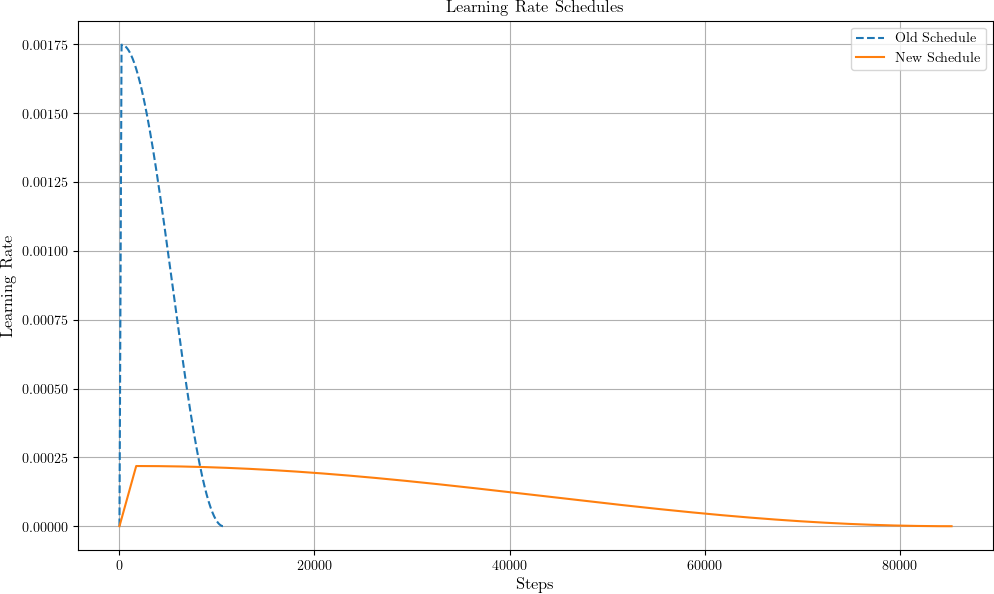

In [15]:
# Plot schedules
jmlr_style = get_style()

def plot_schedules(old_lrs, new_lrs, total_steps_old, total_steps_new):
    with plt.rc_context(jmlr_style):
        plt.figure(figsize=(10, 6))
        plt.plot(range(total_steps_old), old_lrs, label="Old Schedule", linestyle="--")
        plt.plot(range(total_steps_new), new_lrs, label="New Schedule")
        plt.xlabel("Steps")
        plt.ylabel("Learning Rate")
        plt.title("Learning Rate Schedules")
        plt.legend()
        plt.grid()
        plt.show()

# Hyperparameters
old_hparams = {
    "learning_rate": 0.0017486387539278373,
    "warmup_factor": 0.02
}
new_hparams = {
    "learning_rate": 0.0017486387539278373 / 8,  # Scaled by 8
    "warmup_factor": 0.02
}

# Step hints
old_step_hint = 10666  # Adjust to match your original schedule length
new_step_hint = old_step_hint * 8  # New schedule is 8x longer

# Optimizer (dummy with a single parameter)
dummy_param = torch.nn.Parameter(torch.tensor([1.0]))
optimizer_old = SGD([dummy_param], lr=old_hparams["learning_rate"])
optimizer_new = SGD([dummy_param], lr=new_hparams["learning_rate"])

# Schedulers
old_scheduler = pytorch_cosine_warmup(old_step_hint, old_hparams, optimizer_old)
new_scheduler = pytorch_cosine_warmup(new_step_hint, new_hparams, optimizer_new)

# Simulate LR schedules
old_lrs = simulate_schedule(optimizer_old, old_scheduler, old_step_hint)
new_lrs = simulate_schedule(optimizer_new, new_scheduler, new_step_hint)

# Plot
plot_schedules(old_lrs, new_lrs, old_step_hint, new_step_hint)